<a href="https://colab.research.google.com/github/ksairos/tf-advanced-techniques-course/blob/main/course_4/C4_W4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GANs with Hands

Generative Adversarial Network (GAN) that generates pictures of hands. These will be trained on a dataset of hand images doing sign language.

## Imports

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import numpy as np

import urllib.request
import zipfile
from IPython import display

In [ ]:
K = keras.backend

## Some Utilities

In [ ]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

    plt.show()

## Some Constants

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 30000
EPOCHS = 60

random_normal_dimensions = 32

## Get and Prepare the Data

In [ ]:
# download the dataset
training_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Resources/signs-training.zip"
training_file_name = "signs-training.zip"
urllib.request.urlretrieve(training_url, training_file_name)

# extract to local directory
training_dir = "/tmp"
zip_ref = zipfile.ZipFile(training_file_name, 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

In [ ]:
# mapping function for our dataset
def map_images(file):
  '''converts the images to floats and normalizes the pixel values'''
  image = tf.io.decode_png(tf.io.read_file(file))
  image = tf.cast(image, tf.float32)
  image = (image - 127.5) / 127.5 

  return image

# create training batches
filename_dataset = tf.data.Dataset.list_files("/tmp/signs-training/*.png")
image_dataset = filename_dataset.map(map_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
next(image_dataset.take(1).as_numpy_iterator()).shape

(32, 28, 28, 1)

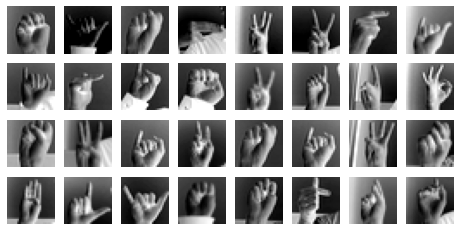

In [ ]:
plot_results(next(image_dataset.take(1).as_numpy_iterator()), 8)

# Type 2

This type is based on the structure provided by the TensorFlow Advanced Techniques specialization

## Build the Model

In [ ]:
# Model building imports

from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Flatten, Reshape, Dense, LeakyReLU, Dropout
from keras.models import Sequential

### Generator

In [ ]:
def make_generator_type2():
  generator = Sequential([
                          
    Dense( 7 * 7 * 128, input_shape=[random_normal_dimensions], activation='selu'),
    Reshape( (7, 7, 128) ),
    BatchNormalization(),

    Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='SAME', activation='selu'),
    BatchNormalization(),

    Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding="SAME", activation='tanh')
  ])

  return generator

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              206976    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

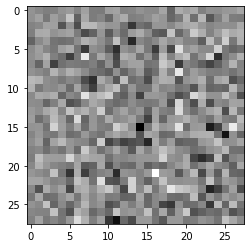

In [ ]:
# sanity check
K.clear_session()

generator2 = make_generator_type2()
generator2.summary()

test_noise = tf.random.normal([1, random_normal_dimensions])

test_image = generator2(test_noise, training=False)

plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.show()

In [ ]:
def make_discriminator_type2():
  discriminator = Sequential([
    Conv2D(64, kernel_size=5, strides=2, padding="SAME", input_shape=(28,28,1)),
    LeakyReLU(0.2),
    Dropout(0.4),

    Conv2D(128, kernel_size=5, strides=2, padding='SAME'),
    LeakyReLU(0.2),
    Dropout(0.4),

    Flatten(),
    Dense(1, activation='sigmoid')
  ])

  return discriminator

In [ ]:
# sanity check
discriminator2 = make_discriminator_type2()
discriminator2.summary()

test_pred = discriminator2(test_image, training=False)

print()
print(test_pred.numpy())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

### Compile Discriminator

In [ ]:
discriminator2.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator2.trainable = False

### Build and Compile GAN model

In [ ]:
gan = Sequential([generator2, discriminator2])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

## Train the model

In [ ]:
def train_gan(gan, dataset, random_normal_dimensions, epochs=50):
  """ Defines the two-phase training loop of the GAN
  Args:
    gan -- the GAN model which has the generator and discriminator
    dataset -- the training set of real images
    random_normal_dimensions -- dimensionality of the input to the generator
    epochs -- number of epochs
  """

  # get generator and discriminator
  generator, discriminator = gan.layers

  for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch + 1, epochs))
    
    for real_images in dataset:
      
      # Phase 1
      # get batch size in case the batch is not full
      real_batch_size = real_images.shape[0]

      # generate noise
      noise = tf.random.normal([real_batch_size, random_normal_dimensions])

      # use noise to generate fake images
      fake_images = generator(noise)

      # create a list of fake and real images
      mixed_images = tf.concat([fake_images, real_images], axis=0)

      # list of labels for the discriminator
      discriminator_labels = tf.constant([[0.]] * real_batch_size + [[1.]] * real_batch_size)

      # unfreeze the discriminator's layers
      discriminator.trainable = True

      # train discriminator on the batch of mixed images
      discriminator.train_on_batch(mixed_images, discriminator_labels)

      # Phase 2
      # again generate some noise 
      noise = tf.random.normal([real_batch_size, random_normal_dimensions])

      # label all generated images as real
      generator_labels = tf.constant([[1.]] * real_batch_size)

      # freeze the discriminator's layers
      discriminator.trainable = False

      # Train the GAN on the noise with the labels all set to be true
      gan.train_on_batch(noise, generator_labels)

    display.clear_output(wait=True)
    plot_results(fake_images, 16)                     
    plt.show()

  return fake_images

In [ ]:
temp_gen, _ = gan.layers
temp_noise = tf.random.normal([BATCH_SIZE, random_normal_dimensions])

some_images = temp_gen(temp_noise)
plot_results(some_images, 16)

In [ ]:
fake_images2 = train_gan(gan, image_dataset, random_normal_dimensions, EPOCHS)

# Type 1

This model is based on the sample presented by TensorFlow documentation on Deep Convolutional Generative Adversarial Networks. 

**Generator** has double amount of units in the first Dense Layer and the last Conv2DTranspose Layer will decrease both spatial dims and channels.

**Discriminator** is pretty much the same in both versions

See details for other parts in the text boxes for each section

## Build the Model

### Generator


In [ ]:
def make_generator_type1():
  model = Sequential()
  
  # Initialize the first Dense Layer of the model with BN and LeakyReLU activation
  model.add(Dense( 7 * 7 * 256 , use_bias=False, input_shape=[random_normal_dimensions]))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Reshape((7, 7, 256)))

  # make sure dimensions are correct
  assert model.output_shape == (None, 7, 7, 256), "{}".format(model.output_shape)

  model.add(Conv2DTranspose(filters=128, kernel_size=5, strides=(1,1), padding="SAME", use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  assert model.output_shape == (None, 7, 7, 128), "{}".format(model.output_shape)

  model.add(Conv2DTranspose(filters=64, kernel_size=5, strides=(2,2), padding="SAME", use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  assert model.output_shape == (None, 14, 14, 64), "{}".format(model.output_shape)

  model.add(Conv2DTranspose(filters=1, kernel_size=5, strides=(2,2), padding="SAME", activation='tanh'))

  assert model.output_shape == (None, 28, 28, 1), "{}".format(model.output_shape)

  return model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12544)             401408    
                                                                 
 batch_normalization_7 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 7, 7, 128)       

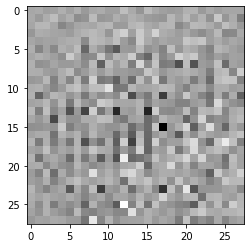

In [ ]:
# sanity check

generator = make_generator_type1()
generator.summary()

test_noise = tf.random.normal([1, random_normal_dimensions])

test_image = generator(test_noise, training=False)

plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.show()

### Discriminator

In [ ]:
def make_discriminator_type1():
  model = Sequential()

  model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='SAME', input_shape=(28,28,1)))
  model.add(LeakyReLU())
  model.add(Dropout(0.4))

  assert model.output_shape == (None, 28, 28, 64), "{}".format(model.output_shape)

  model.add(Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='SAME'))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  assert model.output_shape == (None, 14, 14, 128), "{}".format(model.output_shape)

  model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding='SAME'))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  assert model.output_shape == (None, 7, 7, 256), "{}".format(model.output_shape)

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
# sanity check
discriminator = make_discriminator_type1()
discriminator.summary()

test_pred = discriminator(test_image, training=False)

print()
print(test_pred.numpy())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 dropout_3 (Dropout)         (None, 28, 28, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       204928    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 256)        

### Define Loss and Optimizer

In [ ]:
# Cross-entropy loss

cross_entropy = tf.keras.losses.BinaryCrossentropy()

#### Discriminator Loss
This loss shows how well the model can tell if the image is fake or not

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss

  return total_loss

#### Generator Loss
This loss shows how well the model can "trick" the discriminator to label fake images ("0") as real ("1")

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

#### Optimizers
Different models must have different optimizers. Here we will use Adam optimizer, unlike RMSProp in the Type 2

In [ ]:
generator_optimizer = keras.optimizers.Adam()
discriminator_optimizer = keras.optimizers.Adam()

## Custom Training Loop
Another significant difference between Type 1 and Type 2 models is training process. Here we are using custom training loops unlike train_on_batch() function.

In [ ]:
# decorator @tf.function causes the function to be "compiled"
@tf.function
def train_step(images):
  
  # generate noise
  noise = tf.random.normal([BATCH_SIZE, random_normal_dimensions])

  # use Gradient Tape to store gradients of both generator and discriminator
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  
  gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

  return generated_images

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch+1, epochs))
    
    for real_image_batch in dataset:
      generated_images = train_step(real_image_batch)
    
    display.clear_output(wait=True)
    plot_results(generated_images, n_cols=8)
  return generated_images

### Start training

In [ ]:
fake_images1 = train(image_dataset, EPOCHS)

## Images for grading (Course Assignment)

In [ ]:
# helper function to collect the images
def append_to_grading_images(images, indexes):
  l = []
  for index in indexes:
    if len(l) >= 16:
      print("The list is full")
      break
    l.append(tf.squeeze(images[index:(index+1),...], axis=0))
  l = tf.convert_to_tensor(l)
  return l

In [ ]:
grading_images = tf.concat([append_to_grading_images(some_images, [21, 22, 31, 7]), 
                            append_to_grading_images(fake_images1, [0, 5, 7, 8, 12, 14, 20, 28]),
                            append_to_grading_images(fake_images2, [2, 8, 9, 19])
                            ], axis=0)

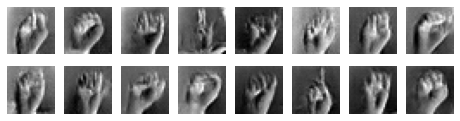

In [ ]:
plot_results(grading_images, 8)

In [ ]:
from PIL import Image
from zipfile import ZipFile

denormalized_images = grading_images * 255
denormalized_images = tf.dtypes.cast(denormalized_images, dtype = tf.uint8)

file_paths = []

for this_image in range(0,16):
  i = tf.reshape(denormalized_images[this_image], [28,28])
  im = Image.fromarray(i.numpy())
  im = im.convert("L")
  filename = "hand" + str(this_image) + ".png"
  file_paths.append(filename)
  im.save(filename)

with ZipFile('my-signs.zip', 'w') as zip:
  for file in file_paths:
    zip.write(file)